In [229]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error,r2_score
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
!pip install shap -q
import shap

# importando o dataset
dados = pd.read_csv("/content/StudentsPerformance.csv")

# renomeando as colunas com underscore
df = dados.rename(columns={
    "reading score": "reading_score",
    "writing score": "writing_score",
    "math score": "math_score",
    "race/ethnicity": "race_ethnicity",
    "parental level of education": "parental_level_education",
    "test preparation course": "test_preparation_course",

})

# instanciando dataset
df.head()

,gender,race_ethnicity,parental_level_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [230]:
print("--------Formato dataset")
# analisando o formato do dataset
print(df.shape)
print("--------Análises descritivas------------")

# análises descritivas
print(df.describe())
print("---------Valores Únicos-------------")

# valores únicos
print(df.nunique())
print("----------Valores Nulos--------------")

# analisando valores nulos
print(df.isnull().sum())

--------Formato dataset
(1000, 8)
--------Análises descritivas------------
       math_score  reading_score  writing_score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000
---------Valores Únicos-------------
gender                       2
race_ethnicity               5
parental_level_education     6
lunch                        2
test_preparation_course      2
math_score                  81
reading_score               72
writing_score               77
dtype: int64
----------Valores Nulos--------------
gender                      0
race_ethnicity              0
parental_level_education    0
lunch                       0
test_preparation_course     0
math_sc

In [231]:
# Metódo escolhido foi Random Forest para dados categóricos e numéricos
# Esse metódo destaca-se pela sua capacidade de calcular a importância de cada feature para o modelo

# colunas que serão usadas para análises
targets = ['gender', 'race_ethnicity', 'parental_level_education', 'lunch',
       'test_preparation_course', 'reading_score',
       'writing_score']

# transformando as colunas em um formato para futuras transformações para modelos de ML
# podemos construir um pipeline para isso
# MinMaxScaler para dados numéricos
# OrdinalEncoder para dados categóricos
# Podemos tratar como apenas uma coluna com valores ordinais
transform = ColumnTransformer(transformers=
       [('num', MinMaxScaler(), selector(dtype_exclude="object")),
       ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')

# Neste exemplo usamos um paramêtro para balancear o peso das classes
# e random state para ter certeza que conseguiremos obter o mesmo resultado a cada vez que reporduzir a célula do código
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

# Definindo nosso pipeline
pipeline = Pipeline([('prep', transform),
                     ('clf', clf)])

In [232]:
# Separando nossos dados entre treino e teste
X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(df[targets], df['math_score'], test_size=0.3, random_state=0)

# Fitando o modelo com os dados de treino
pipeline.fit(X_train_pipe, y_train_pipe)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c8e0b99f6d0>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c8e0b99c650>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [233]:
# Referenciando o modelo com as métricas de importãncia para cada feature em um conjunto
pipeline['clf'].feature_importances_

array([0.31238584, 0.31178984, 0.05053078, 0.12148336, 0.13179582,
       0.03035196, 0.0416624 ])

In [234]:
# Visualização das features e  análise de contribuição de cada feature
# A última coluna da tabela representava o total restante para a coluna somar a 1
# A segunda coluna representa o verdadeiro total da importância que a coluna soma para a construção
# para cada feature que recebe um score menor que 0.5, essa variável pode ser cortada para a construção
feat_list = []

total_importance = 0

# Podemos visualizar a importância através do coeficiente de gini
for feature in zip(targets, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

# Lista vazia para adição das features
included_feats = []

# Visualização do nome da feature e score de importância
for feature in zip(targets, pipeline['clf'].feature_importances_):
    if feature[1] > .05:
        included_feats.append(feature[0])

# Total de importância comparado a uma escala que varia de 0 a 1
print('n',"Cumulative Importance =", total_importance)

# Criação da tabela após análise
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp

n Cumulative Importance = 1.0


,FEATURE,IMPORTANCE,CUMSUM
0,gender,0.312386,0.312386
1,race_ethnicity,0.311790,0.624176
4,test_preparation_course,0.131796,0.755971
3,lunch,0.121483,0.877455
2,parental_level_education,0.050531,0.927986
6,writing_score,0.041662,0.969648
5,reading_score,0.030352,1.000000


In [235]:
# Seleção das variáveis com maior score de importância para o modelo
# Nesse caso selecionaremos as 5 melhores para obter melhor performance do modelo
print('Features mais importantes:')
print(included_feats)
print('Números de features inclusas =', len(included_feats))

Features mais importantes:
['gender', 'race_ethnicity', 'parental_level_education', 'lunch', 'test_preparation_course']
Números de features inclusas = 5


In [236]:
# Para evitar multicolinearidade para que as variáveis apresentam informações independentes
# Para detectar a relação entre as duas variáveis iremos usar a métrica de fator de inflação de variãncia(VIF)
# como mensurar o VIF:
# VIF = 1 Não há correlação entre a variável preditora e as outras variáveis independentes
# VIF entre 1 e 5: tem uma correlação moderada
# VIF > 5: Tem uma grande correlação entre as duas variáveis para a variável preditora

# Nesse caso iremos testar a coorrelação entre as variáveis reading e writing para math score
# y_testing e X_testing nomeadas nesas veriáveis não significa que treinaremos o modelo

# usando math score para avaliar a relação entre as duas variáveis
y_testing, X_testing = dmatrices('math_score ~ reading_score + writing_score',
                 data=df,
                 return_type='dataframe')

# criamos o dataframe para as variáveis testadas
vif_df = pd.DataFrame()
vif_df['variable'] = X_testing.columns

# Cálculo testando a relação entre as variáveis independentes e a variável preditora
vif_df['VIF'] = [variance_inflation_factor(X_testing.values, i) for i in range(X_testing.shape[1])]

# Visualização do dataframe
print(vif_df)
# Aqui podemos notar que há uma forte correlação entre essas duas variáveis já que VIF > 5
# Portanto elas não serão capazes de fornecer informações de forma independente

        variable        VIF
0      Intercept  23.488525
1  reading_score  11.268556
2  writing_score  11.268556


<Axes: >

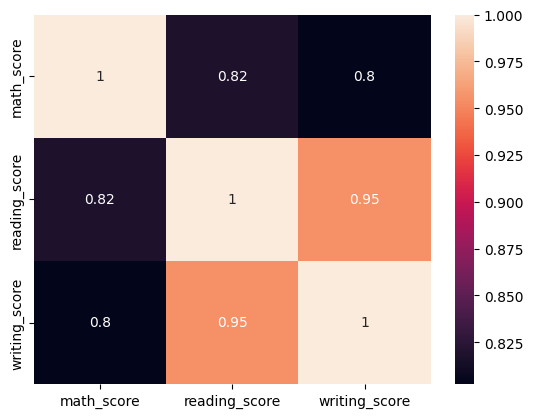

In [237]:
# Dataset apenas valores numéricos
df_num = df.drop(['gender', 'lunch', 'test_preparation_course', 'race_ethnicity', 'parental_level_education'], axis=1)
df_num

# Instanciando matriz de correlação
correlation = df_num.corr()

sns.heatmap(correlation,
            xticklabels=correlation.columns,
            yticklabels=correlation.columns,
            annot=True)

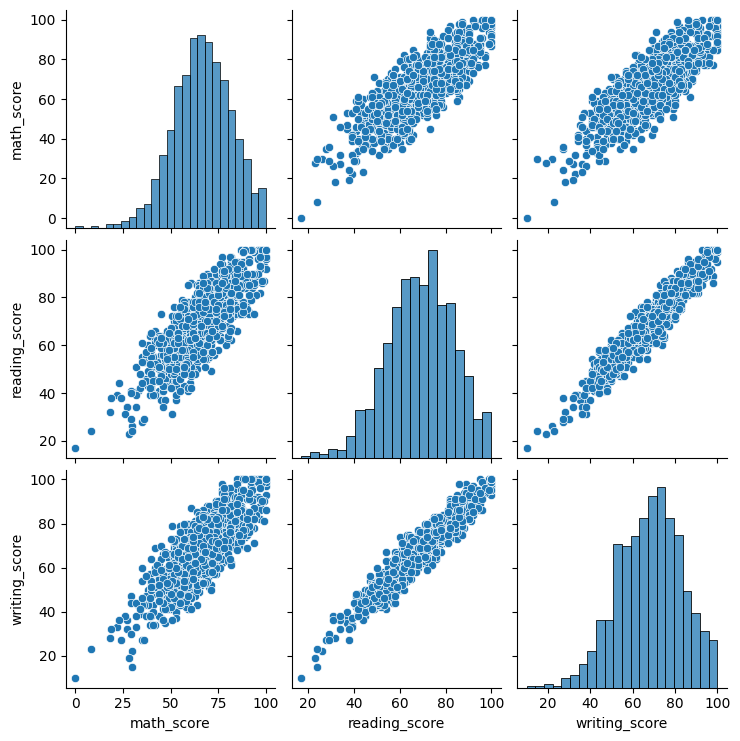

In [238]:
# Visualizando correlação entre apenas duas variáveis
# Podemos notar que todas as correlações são lineares positivas, e as distribuições apresentam inclinação a esquerda ou negativa
sns.pairplot(df_num)

<Axes: xlabel='math_score', ylabel='reading_score'>

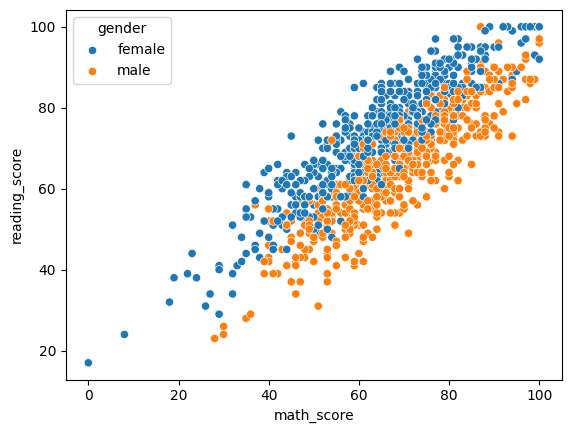

In [239]:
# relação entre math score e reading score considerando gender, aqui podemos observar a correlção entre dois sets, masculino e feminino, há uma correlção positiva entre as duas variáveis, mas podemos notar que as mulheres obtiveram resultados melhores para testes de leitura e matemática, sendo superior ao set dos homens
sns.scatterplot(data=df, x="math_score", y="reading_score", hue="gender")

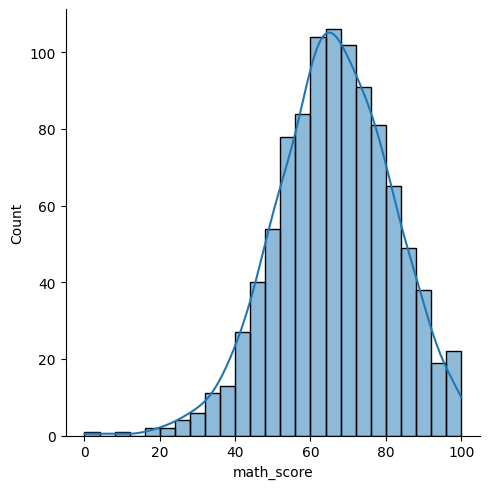

In [240]:
# Apresentação de histograma, cada barra agrupa números em range, com o formato e distribuição dos dados, novamente como apresentado anteriormente, a distribuição para math score apresenta uma inclinação a esquerda, sendo a maior frequência de resultado dos testes aproximadamente 70
sns.displot(data=df, x="math_score", kde=True)

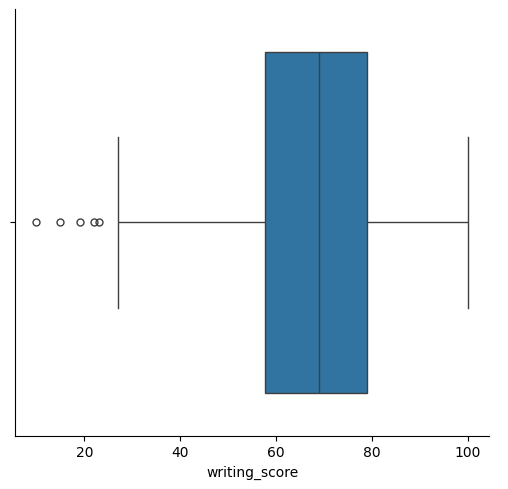

In [241]:
# Apresentação de boxplot para writing score, os whiskers são relativamente iguais, mas o esquerdo sendo mais longo, e maior concentração de dados entre o intervalo de 55 -80
sns.catplot(data=df, x="writing_score", kind="box")

In [242]:
# Usando técnica de encoding para modelagem de ML
# Usaremos Label encoding do Scikit-learn:) para que não haja ordenamento das classes

# dicionário vazio para adição das variáveis categóricas
label_encoders = {}
categorical_columns = ['gender', 'race_ethnicity', 'parental_level_education', 'lunch', 'test_preparation_course']

# Encoding para cada variável
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [243]:
df

,gender,race_ethnicity,parental_level_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75
...,...,...,...,...,...,...,...,...
995,0,4,3,1,0,88,99,95
996,1,2,2,0,1,62,55,55
997,0,2,2,0,0,59,71,65
998,0,3,4,1,0,68,78,77


In [244]:
# Colunas para diferentes testes
colunas_test1 = [
    "gender",
    "race_ethnicity",
    "test_preparation_course",
    "lunch",
    "writing_score",
]
colunas_test2 = [
    "gender",
    "race_ethnicity",
    "test_preparation_course",
    "lunch",
    "reading_score",
]

colunas_test3 = [
    "gender",
    "race_ethnicity",
    "test_preparation_course",
    "lunch",
    "reading_score",
    "writing_score"
]

In [245]:
def linear_regression(data, vars):
    """ Função que utiliza um dataset e suas respectivas colunas para aplicação de regressão linear,
        com a variável preditora math score já configurada na função.
    """
    X = data[vars]
    Y = data['math_score']

    # Separando o dataset entre variáveis de treino e teste
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Instanciando modelo de Regressão
    model = LinearRegression()

    # Fitando o modelo com os dados de treino
    model.fit(X_train, Y_train)

    # Fazendo predição nos dados de teste
    Y_pred = model.predict(X_test)

    # Calculando métricas
    mae = metrics.mean_absolute_error(Y_test, Y_pred)
    mse = metrics.mean_squared_error(Y_test, Y_pred)
    rmse = root_mean_squared_error(Y_test, Y_pred)
    r2 = metrics.r2_score(Y_test, Y_pred)

    # Imprimindo as métricas
    print("Métricas de Regressão:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print("\nCoeficientes:")
    for var, coef in zip(vars, model.coef_):
        print(f"{var}: {coef:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Coefficients': model.coef_,
        'Intercept': model.intercept_
    }

In [246]:
# Chamando a função de linear regression
resultados_test1 = linear_regression(df, colunas_test1)
print("-------------------------------------")
resultados_test2 = linear_regression(df, colunas_test2)

Métricas de Regressão:
MAE: 4.3564
MSE: 30.6960
RMSE: 5.5404
R²: 0.8739

Coeficientes:
gender: 13.4713
race_ethnicity: 0.7766
test_preparation_course: 3.4374
lunch: 3.4991
writing_score: 0.9355
Intercept: -10.1442
-------------------------------------
Métricas de Regressão:
MAE: 4.6269
MSE: 35.2143
RMSE: 5.9342
R²: 0.8553

Coeficientes:
gender: 11.3349
race_ethnicity: 1.0638
test_preparation_course: 0.8164
lunch: 4.7821
reading_score: 0.9044
Intercept: -7.7525


In [247]:
def decision_tree_regression(
    data,
    vars,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
):

    """ Função que utiliza um dataset e suas respectivas colunas para aplicação de decision tree regression,
        com a variável preditora math score já configurada na função.
    """

    X = data[vars]
    Y = data["math_score"]

    # Separando o dataset entre variáveis de treino e teste
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=random_state
    )

    # Instanciando modelo de Decision tree regressor
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state,
    )

    # Fitando o modelo com os dados de treino
    model.fit(X_train, Y_train)

    # Fazendo predição nos dados de teste
    Y_pred = model.predict(X_test)

    # Calculando métricas
    mae = metrics.mean_absolute_error(Y_test, Y_pred)
    mse = metrics.mean_squared_error(Y_test, Y_pred)
    rmse = root_mean_squared_error(
        Y_test, Y_pred
    )
    r2 = metrics.r2_score(Y_test, Y_pred)

    # Imprimindo as métricas
    print("Regression Metrics (Árvore de Decisão):")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "model": model,
        "X_test": X_test
    }

In [248]:
# Testando a função de decision tree regressor com diferentes parâmetros
dt_results_list = []
max_depth_values = [2, 5, 10, 15, 20]

for depth in max_depth_values:
    print(f"\nTesting with max_depth={depth}")
    results = decision_tree_regression(df, colunas_test3, max_depth=depth)
    results['max_depth'] = depth  # Adicionando cada valor do paramêtro para o dicionário
    dt_results_list.append(results)

# Criando o dataframe com a lista de resultados obtidos
dt_metrics_df = pd.DataFrame(dt_results_list)

# Visualizando os resultados com as métricas desejadas
display(dt_metrics_df[['max_depth', 'MAE', 'MSE', 'RMSE', 'R2']])


Testing with max_depth=2
Regression Metrics (Árvore de Decisão):
MAE: 8.0000
MSE: 109.2660
RMSE: 10.4530
R²: 0.5510

Testing with max_depth=5
Regression Metrics (Árvore de Decisão):
MAE: 4.9315
MSE: 42.7716
RMSE: 6.5400
R²: 0.8242

Testing with max_depth=10
Regression Metrics (Árvore de Decisão):
MAE: 5.8647
MSE: 54.8600
RMSE: 7.4068
R²: 0.7746

Testing with max_depth=15
Regression Metrics (Árvore de Decisão):
MAE: 6.2942
MSE: 63.9590
RMSE: 7.9974
R²: 0.7372

Testing with max_depth=20
Regression Metrics (Árvore de Decisão):
MAE: 6.3025
MSE: 63.8888
RMSE: 7.9930
R²: 0.7374


,max_depth,MAE,MSE,RMSE,R2
0,2,7.999989,109.265982,10.453037,0.550971
1,5,4.931523,42.771610,6.540001,0.824230
2,10,5.864739,54.860016,7.406755,0.774553
3,15,6.294167,63.959028,7.997439,0.737160
4,20,6.302500,63.888750,7.993044,0.737449


Regression Metrics (Árvore de Decisão):
MAE: 4.9315
MSE: 42.7716
RMSE: 6.5400
R²: 0.8242


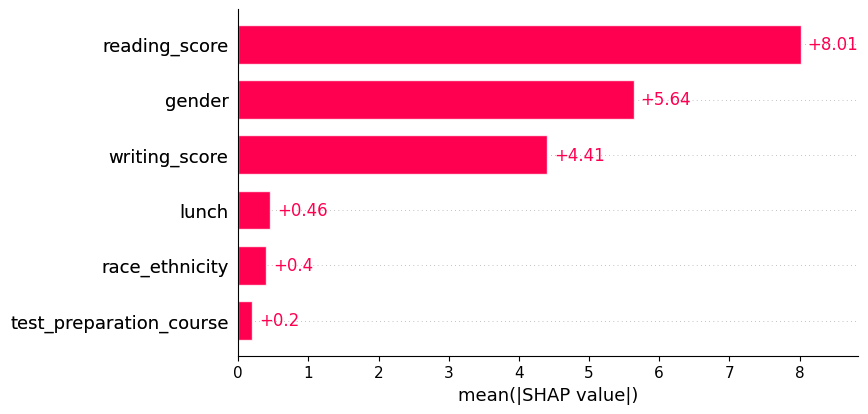

In [249]:
# Coletando os resultados com as predições usando a função de decision tree
dt_results = decision_tree_regression(df, colunas_test3)
dt_model = dt_results["model"]
dt_X_test = dt_results["X_test"]

# Explicando as predições do modelo usando SHAP
dt_explainer = shap.Explainer(dt_model)
dt_shap_values = dt_explainer(dt_X_test)

# Visualizando as predições usando o gráfico estilo waterfall e sua primeria predição
# shap.plots.waterfall(dt_shap_values[0])
# shap.plots.force(dt_shap_values)
# shap.plots.beeswarm(dt_shap_values)
shap.plots.bar(dt_shap_values)

# Podemos notar as relações que cada feature contribuiu para o modelo
# Features que estão em vermelho obtiveram resultados melhores aumentando o poder de explicabilidade e predição do modelo
# Já para as features em azul elas obtiveram os piores resultados
# Neste gráfico podemos notar que reading score foi a feature que mais contribui para a predição do modelo de decision tree

In [250]:
def xgboost_regression(
    data,
    vars,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
):

    """ Função que utiliza um dataset e suas respectivas colunas para aplicação de xgboost regression,
        com a variável preditora math score já configurada na função.
    """

    X = data[vars]
    Y = data["math_score"]

    # Separando o dataset entre variáveis de treino e teste
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=random_state
    )

    # Instanciando modelo de Decision tree regressor
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=random_state,
    )

    # Fitando o modelo com os dados de treino
    model.fit(X_train, Y_train)

    # Fazendo predição nos dados de teste
    Y_pred = model.predict(X_test)

    # Calculando métricas
    mae = metrics.mean_absolute_error(Y_test, Y_pred)
    mse = metrics.mean_squared_error(Y_test, Y_pred)
    rmse = root_mean_squared_error(Y_test, Y_pred)
    r2 = metrics.r2_score(Y_test, Y_pred)

    # Imprimindo as métricas
    print("Regression Metrics (XGBoost):")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "model": model,
        "X_test": X_test
    }

In [251]:
# Testando a função de xgboost com diferentes parâmetros para números de estimadores
xgb_results_list = []
n_estimators_values = [50, 100, 200]

for n_estimators in n_estimators_values:
    print(f"\nTesting with n_estimators={n_estimators}")
    results = xgboost_regression(df, colunas_test3, n_estimators=n_estimators)
    results['n_estimators'] = n_estimators
    xgb_results_list.append(results)

# Criando o dataframe com a lista de resultados obtidos
xgb_metrics_df = pd.DataFrame(xgb_results_list)

# Visualizando os resultados com as métricas desejadas
display(xgb_metrics_df[['n_estimators', 'MAE', 'MSE', 'RMSE', 'R2']])


Testing with n_estimators=50
Regression Metrics (XGBoost):
MAE: 4.3874
MSE: 32.9025
RMSE: 5.7361
R²: 0.8648

Testing with n_estimators=100
Regression Metrics (XGBoost):
MAE: 4.3185
MSE: 31.3949
RMSE: 5.6031
R²: 0.8710

Testing with n_estimators=200
Regression Metrics (XGBoost):
MAE: 4.3472
MSE: 31.5791
RMSE: 5.6195
R²: 0.8702


,n_estimators,MAE,MSE,RMSE,R2
0,50,4.387419,32.902523,5.736072,0.864787
1,100,4.318544,31.394922,5.603117,0.870982
2,200,4.347153,31.579111,5.619529,0.870226


Regression Metrics (XGBoost):
MAE: 4.3185
MSE: 31.3949
RMSE: 5.6031
R²: 0.8710


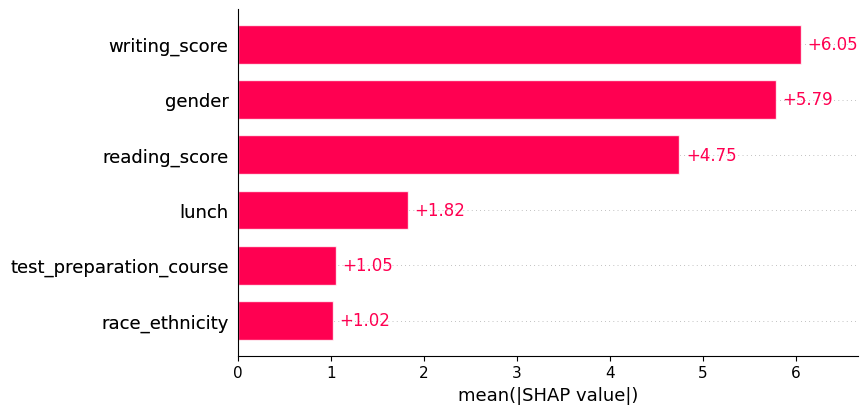

In [252]:
# Coletando os resultados com as predições usando a função de xgboost
xgb_results = xgboost_regression(df, colunas_test3)
model = xgb_results["model"]
X_test = xgb_results["X_test"]

# Explicando as predições do modelo usando SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualizando as predições usando o gráfico de barras
shap.plots.bar(shap_values)

In [253]:
# Criando o dataframe com as métricas obtidas
metrics_data = {
    'Model': ['Linear Regression (Test 1)', 'Linear Regression (Test 2)', 'Decision Tree', 'XGBoost'],
    'MAE': [resultados_test1['MAE'], resultados_test2['MAE'], dt_results['MAE'], xgb_results['MAE']],
    'MSE': [resultados_test1['MSE'], resultados_test2['MSE'], dt_results['MSE'], xgb_results['MSE']],
    'RMSE': [resultados_test1['RMSE'], resultados_test2['RMSE'], dt_results['RMSE'], xgb_results['RMSE']],
    'R2': [resultados_test1['R2'], resultados_test2['R2'], dt_results['R2'], xgb_results['R2']]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Model,MAE,MSE,RMSE,R2
0,Linear Regression (Test 1),4.356449,30.696043,5.540401,0.873855
1,Linear Regression (Test 2),4.626883,35.214281,5.934162,0.855287
2,Decision Tree,4.931523,42.771610,6.540001,0.824230
3,XGBoost,4.318544,31.394922,5.603117,0.870982
